In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torchinfo import summary
import copy
import time

In [2]:
device = torch.device('cpu')
device

device(type='cpu')

# Many to One RNN

We shall treat one dimension of the image as the **feature size** and the other dimension as the **sequence**

We would look at one row at a time, and each row being a sequence input

In [3]:
input_size = 28 # One row at a time, hence input dimension would be (1,28)
sequence_length = 28
hidden_size = 128
num_classes = 10 # 0 to 9 digits
num_epochs = 8
batch_size = 128 # Preferred to be a power of 2
learning_rate = 0.001
num_layers = 3 # Deep RNN layers

In [4]:
train_dataset = torchvision.datasets.MNIST(
    root = '../datasets', 
    train = True, 
    transform = transforms.ToTensor(), 
    download = True
)

test_dataset = torchvision.datasets.MNIST(
    root = '../datasets', 
    train = False, 
    transform = transforms.ToTensor(), 
    download = True
)

In [5]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False
)

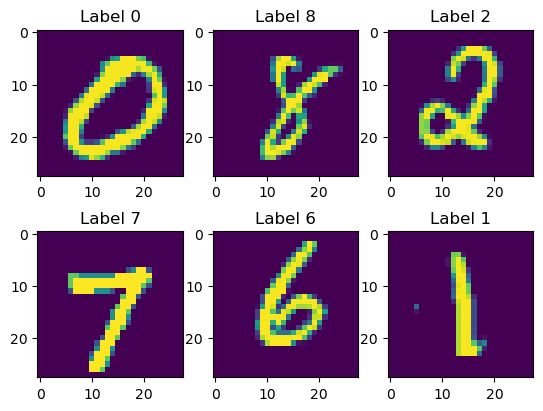

In [6]:
inputs, labels = next(iter(train_loader))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(inputs[i][0]) # 6 from batch-size of 128
    plt.title(f'Label {labels[i]}')

# Recurrent Neural Network (RNN)

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes) -> None:
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
        # batch_first = True means, batch size is the first dimension
        # Would mean x --> (batch_size, seq, input_size)
        # input_size is the feature size

        self.fc = nn.Linear(hidden_size, num_classes) # Last cell unit output

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Dimensions (number of layers, batch_size, hidden_size)
        # Reason - Each layer would have a different hidden state of size (batch_size, hidden_size)

        out, _ = self.rnn(x, h0) # Returns output and hidden state of EACH cell
        # out dimenions: (batch_size, sequence_length, hidden_size)
        # out: (N, 28, 128)
        out = out[:,-1,:] # Since we only want the output of the last cell
        out = self.fc(out)
        return(out)

In [8]:
rnn = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [10]:
n_total_steps = len(train_loader)
n_total_steps

469

In [11]:
summary(rnn, (batch_size, sequence_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [128, 10]                 --
├─RNN: 1-1                               [128, 28, 128]            86,272
├─Linear: 1-2                            [128, 10]                 1,290
Total params: 87,562
Trainable params: 87,562
Non-trainable params: 0
Total mult-adds (M): 309.36
Input size (MB): 0.40
Forward/backward pass size (MB): 3.68
Params size (MB): 0.35
Estimated Total Size (MB): 4.43

In [12]:
tic = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # original shape: [batch_size, 1, 28, 28]
        # Resize: [batch_size, 28, 28]
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        outputs = rnn(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}; Loss: {loss.item():.4f}')
print(f'Finished Training in {(time.time()-tic)//60:.0f}m {(time.time()-tic)%60:.0f}s')

Epoch 1/8; Loss: 0.4875
Epoch 2/8; Loss: 0.1731
Epoch 3/8; Loss: 0.2080
Epoch 4/8; Loss: 0.1113
Epoch 5/8; Loss: 0.0170
Epoch 6/8; Loss: 0.0222
Epoch 7/8; Loss: 0.0487
Epoch 8/8; Loss: 0.0604
Finished Training in 1m 13s


In [13]:
# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = rnn(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the RNN on the 10000 test images: {acc} %')

Accuracy of the RNN on the 10000 test images: 96.83 %


# Gated Recurrent Unit (GRU)

In [14]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes) -> None:
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first = True)
        # batch_first = True means, batch size is the first dimension
        # Would mean x --> (batch_size, seq, input_size)
        # input_size is the feature size

        self.fc = nn.Linear(hidden_size, num_classes) # Last cell unit output

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Dimensions (number of layers, batch_size, hidden_size)
        # Reason - Each layer would have a different hidden state of size (batch_size, hidden_size)

        out, _ = self.gru(x, h0) # Returns output and hidden state of EACH cell
        # out dimenions: (batch_size, sequence_length, hidden_size)
        # out: (N, 28, 128)
        out = out[:,-1,:] # Since we only want the output of the last cell
        out = self.fc(out)
        return(out)

In [15]:
gru = GRU(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)

In [16]:
summary(gru, (batch_size, sequence_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [128, 10]                 --
├─GRU: 1-1                               [128, 28, 128]            258,816
├─Linear: 1-2                            [128, 10]                 1,290
Total params: 260,106
Trainable params: 260,106
Non-trainable params: 0
Total mult-adds (M): 927.76
Input size (MB): 0.40
Forward/backward pass size (MB): 3.68
Params size (MB): 1.04
Estimated Total Size (MB): 5.12

In [17]:
tic = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # original shape: [batch_size, 1, 28, 28]
        # Resize: [batch_size, 28, 28]
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        outputs = gru(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}; Loss: {loss.item():.4f}')
print(f'Finished Training in {(time.time()-tic)//60:.0f}m {(time.time()-tic)%60:.0f}s')

Epoch 1/8; Loss: 0.1865
Epoch 2/8; Loss: 0.1154
Epoch 3/8; Loss: 0.0415
Epoch 4/8; Loss: 0.0533
Epoch 5/8; Loss: 0.0067
Epoch 6/8; Loss: 0.0139
Epoch 7/8; Loss: 0.0018
Epoch 8/8; Loss: 0.0255
Finished Training in 4m 7s


In [18]:
# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = gru(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the GRU on the 10000 test images: {acc} %')

Accuracy of the GRU on the 10000 test images: 98.72 %


# Long Short-Term Memory (LSTM)

In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes) -> None:
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        # batch_first = True means, batch size is the first dimension
        # Would mean x --> (batch_size, seq, input_size)
        # input_size is the feature size

        self.fc = nn.Linear(hidden_size, num_classes) # Last cell unit output

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # Initial cell state
        # Dimensions (number of layers, batch_size, hidden_size)
        # Reason - Each layer would have a different hidden state of size (batch_size, hidden_size)

        out, _ = self.lstm(x, (h0, c0)) # Returns output, (hidden state, cell_state) of EACH cell
        # out dimenions: (batch_size, sequence_length, hidden_size)
        # out: (N, 28, 128)
        out = out[:,-1,:] # Since we only want the output of the last cell
        out = self.fc(out)
        return(out)

In [20]:
lstm = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [21]:
summary(lstm, (batch_size, sequence_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [128, 10]                 --
├─LSTM: 1-1                              [128, 28, 128]            345,088
├─Linear: 1-2                            [128, 10]                 1,290
Total params: 346,378
Trainable params: 346,378
Non-trainable params: 0
Total mult-adds (G): 1.24
Input size (MB): 0.40
Forward/backward pass size (MB): 3.68
Params size (MB): 1.39
Estimated Total Size (MB): 5.47

In [22]:
tic = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # original shape: [batch_size, 1, 28, 28]
        # Resize: [batch_size, 28, 28]
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        outputs = lstm(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}; Loss: {loss.item():.4f}')
print(f'Finished Training in {(time.time()-tic)//60:.0f}m {(time.time()-tic)%60:.0f}s')

Epoch 1/8; Loss: 0.1399
Epoch 2/8; Loss: 0.0913
Epoch 3/8; Loss: 0.0936
Epoch 4/8; Loss: 0.0567
Epoch 5/8; Loss: 0.0114
Epoch 6/8; Loss: 0.0388
Epoch 7/8; Loss: 0.0673
Epoch 8/8; Loss: 0.0296
Finished Training in 5m 9s


In [23]:
# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = lstm(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the LSTM on the 10000 test images: {acc} %')

Accuracy of the LSTM on the 10000 test images: 98.66 %
